# Importing Data

In [ ]:
from google.colab import drive
import zipfile

drive.mount('/content/drive' , force_remount=True)

base_directory = '/content/drive/MyDrive/NNDL_HW3/'
zip_file_path = base_directory + 'archive.zip'
output_path = base_directory + 'Data/'

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(output_path)

# # aquarium_pretrain

# print("Archive has been unzipped to:", output_path)

Mounted at /content/drive


# CustomDataSet

images_dir : /content/drive/MyDrive/NNDL_HW3/Data/aquarium_pretrain/train/images/
labels_dir : /content/drive/MyDrive/NNDL_HW3/Data/aquarium_pretrain/train/labels/
keys : ['0', '3', '2', '5', '4', '6', '1']
values : [3922, 350, 660, 156, 518, 272, 770]


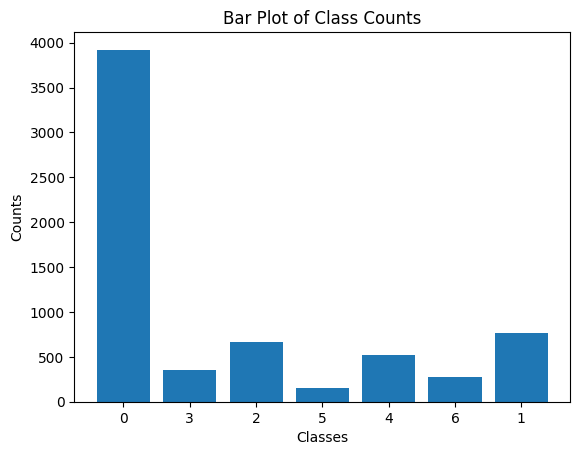

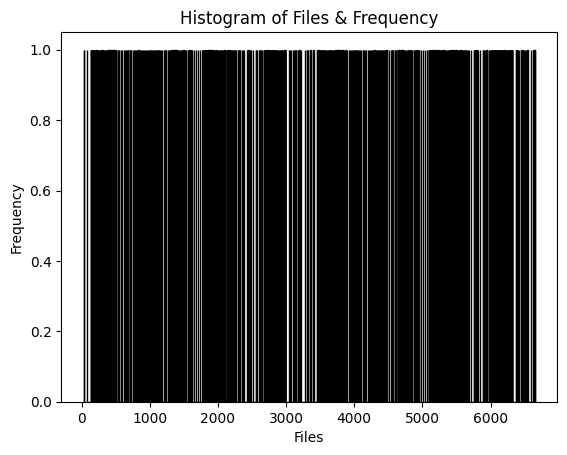

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch
from PIL import Image
import os
import torchvision
from torchvision.models.detection import FasterRCNN
import torchvision.models as models
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torch.utils.data import DataLoader, RandomSampler
from torchvision.models.detection import backbone_utils
import random
import matplotlib.pyplot as plt


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.images = []
        self.labels = []

        images_dir = os.path.join(root_dir, 'images/')
        labels_dir = os.path.join(root_dir, 'labels/')

        print(f'images_dir : {images_dir}')
        print(f'labels_dir : {labels_dir}')

        extension = "txt"

        for image_name in os.listdir(images_dir):
            image_path = images_dir + image_name
            label_name = image_path[:-3] + extension

            label_name = label_name.replace('/images/' , '/labels/')
            label_path = label_name

            if os.path.isfile(image_path) and os.path.isfile(label_path):
                self.images.append(image_path)
                self.labels.append(label_path)

    def eda_analysis(self , labels_dir):
        class_counts = {}
        object_counts = {}
        txt_files = [file for file in os.listdir(labels_dir) if file.endswith('.txt')]

        first_chars = []

        line_count = 0
        for file in txt_files:
            # print(f'file : {file}')

            with open(os.path.join(labels_dir, file), 'r') as f:
                for line in f:
                  line_count = line_count + 1

                  if line[0] in class_counts:
                    # print(f'line[0] : {line[0]}')
                    class_counts[line[0]] = class_counts[line[0]] + 1
                  else :
                    class_counts[line[0]] = 1

                  object_counts[file] = line_count

        # Extract values from the dictionary
        keys = list(class_counts.keys())
        values = list(class_counts.values())
        print(f'keys : {keys}')
        print(f'values : {values}')

        plt.bar(keys, values)
        plt.xlabel('Classes')
        plt.ylabel('Counts')
        plt.title('Bar Plot of Class Counts')
        plt.show()

        keys = list(object_counts.keys())
        values = list(object_counts.values())
        # Plot histogram
        plt.hist(values, bins=range(min(values), max(values) + 1), edgecolor='black')
        plt.xlabel('Files')
        plt.ylabel('Frequency')
        plt.title('Histogram of Files & Frequency')
        plt.show()

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label_path = self.labels[idx]

        image = Image.open(image_path).convert("RGB")
        label = Image.open(label_path).convert("RGB")

        if self.transforms:
            image = self.transforms(image)
            label = self.transforms(label)

        return image, label

    def __len__(self):
      return len(self.images)


output_path = '/content/drive/MyDrive/NNDL_HW3/Data/aquarium_pretrain/train/'
dataset = CustomDataset(output_path)

labels_dir = '/content/drive/MyDrive/NNDL_HW3/Data/aquarium_pretrain/train/labels/'
images_dir = '/content/drive/MyDrive/NNDL_HW3/Data/aquarium_pretrain/train/images/'

sampler = RandomSampler(dataset)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True )

dataset.eda_analysis(labels_dir)

# Load the pretrained Res2Net101 backbone
backbone = models.resnet101(pretrained=True)
NUM_FINETUNE_CLASSES = 7

# Use Backbones

In [ ]:
import torchvision.models as models
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

backbone = models.resnet101(pretrained=True)
NUM_FINETUNE_CLASSES = 7

in_features = backbone.fc.in_features

backbone.fc = torch.nn.Linear(in_features, NUM_FINETUNE_CLASSES)
backbone.out_channels = 20


model = FasterRCNN(backbone, num_classes = NUM_FINETUNE_CLASSES)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_FINETUNE_CLASSES)

# Collate fn

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    images, labels = zip(*batch)

    # Convert PIL images to tensors
    images = [torchvision.transforms.functional.to_tensor(image) for image in images]
    labels = [torchvision.transforms.functional.to_tensor(label) for label in labels]

    images = pad_sequence(images, batch_first=True, padding_value=0)
    labels = pad_sequence(labels, batch_first=True, padding_value=0)

    images = torch.stack(images, dim=0)
    labels = torch.stack(labels, dim=0)

    return images, labels

# Padding images and labels

In [ ]:
import torch
from torchvision.transforms import functional as F

def pad_images_and_targets(batch):
    images , targets = zip(*batch)

    max_height = max(img.shape[0] for img in images )
    max_width = max(img.shape[1] for img in images)

    padded_images  = []
    padded_targets = []

    for index , (img, target) in enumerate(zip(images, targets)):
        pad_height = max_height - img.shape[0]
        pad_width = max_width - img.shape[1]
        # print(f'target : {target}')

        padded_img = F.pad(img, (0, pad_width, 0, pad_height))
        padded_images.append(padded_img)

        # Update bounding box coordinates in the target
        # print('------------ target ---------------------')
        # for each in target :
        #   print(f'target : {target}')

        # for item in target :
        #   item["boxes"][:, 0] += pad_width // 2
        #   item["boxes"][:, 1] += pad_height // 2

        padded_targets.append(target)

    # print(f'length of padded_images : {len(padded_images)} \n length of padded_targets : {len(padded_targets)}')
    return padded_images, padded_targets

# Custom DataSet

In [ ]:
import os
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.images = []
        self.labels = []
        images_dir = os.path.join(root_dir, 'images/')
        labels_dir = os.path.join(root_dir, 'labels/')
        extension = "txt"

        for image_name in os.listdir(images_dir):
            image_path = os.path.join(images_dir, image_name)
            label_name = image_name[:-3] + extension
            label_path = os.path.join(labels_dir, label_name)

            if os.path.isfile(image_path) and os.path.isfile(label_path):
                self.images.append(image_path)
                self.labels.append(label_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label_path = self.labels[idx]

        image = Image.open(image_path).convert("RGB")
        label = []

        with open(label_path, 'r') as f:
            for line in f:
                class_id, x1, y1, x2 , y2 = map(float, line.strip().split())
                label.append({
                    'boxes': torch.tensor([[x1, y1, x2 , y2]]),
                    'labels': torch.tensor([class_id]),
                })

        if self.transforms:
            image = self.transforms(image)

        # padded_image , padded_label = pad_images_and_targets(image , label)
        return image , label


transform = transforms.Compose([
    transforms.ToTensor(),
])


dataset = CustomDataset(output_path, transforms=transform)

data_loader = DataLoader(dataset, batch_size=4, shuffle=True , collate_fn = pad_images_and_targets)



# Parameters

In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torchvision.ops import nms

backbone = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)


model = fasterrcnn_resnet50_fpn(pretrained = False , pretrained_backbone=False)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

Downloading: "https://github.com/pytorch/vision/zipball/v0.9.0" to /root/.cache/torch/hub/v0.9.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 85.7MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python

# Training Loop

In [ ]:
# # Train the model using the DataLoader
# for images, targets in data_loader:
#     # images = [F.to_tensor(image) for image in images]
#     # targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#     new_targets = []
#     for target in targets:
#         new_target = {i: v for i, v in enumerate(target)}
#         # print(f'new_target : {new_target}')
#         new_targets.append(new_target)
#     # print(f'new_targets : {new_targets}')

#     model.train()
#     optimizer.zero_grad()

#     for i in range(len(new_targets)):
#       print(f'new_target[{i}] : {new_targets[i]}')
#       loss_dict = model(images , new_targets[i])
#       losses = sum(loss for loss in loss_dict.values())
#       losses.backward()
#       optimizer.step()

#     # Evaluate the model
#     model.eval()
#     with torch.no_grad():
#         outputs = model(images)
#         # Perform non-maximum suppression (NMS) on the outputs
#         detections = [{k: v.cpu() for k, v in t.items()} for t in outputs]
#         detections = nms(detections, iou_threshold=0.5)

#         # Process the detections as needed

# # Save or further use the trained model

In [ ]:
# Main training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for images, targets in data_loader:
        images = [F.to_tensor(image) if not isinstance(image, torch.Tensor) else image for image in images]

        new_targets = []

        for target_list in targets:
            for target_dict in target_list:
                boxes = target_dict['boxes']
                labels = target_dict['labels']

                # print(f'boxes : {boxes}')

                # Convert boxes to (x1, y1, x2, y2) format
                # boxes = torch.cat((boxes[:, :2], boxes[:, 2:] - boxes[:, :2]), 1)

                new_target = {
                    'boxes': boxes,
                    'labels': labels
                }

                new_targets.append(new_target)
       # Assuming model is your Faster R-CNN model


        optimizer.zero_grad()
        loss_dict = model(images, new_targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        for images, _ in data_loader:
            images = [F.to_tensor(image) if not isinstance(image, torch.Tensor) else image for image in images]
            outputs = model(images)
            detections = [{k: v.cpu() for k, v in t.items()} for t in outputs]
            detections = nms(detections, iou_threshold=0.5)

            # Process the detections as needed

    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {losses.item()}')

print('Training complete.')

AssertionError: All bounding boxes should have positive height and width. Found invalid box [0.78125, 0.4493446350097656, 0.4475911259651184, 0.2195892333984375] for target at index 0.

# OHEM

In [ ]:
import random

class OHEMDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, ratio=0.5):
        self.dataset = dataset
        self.ratio = ratio

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get the original sample
        sample = self.dataset[idx]
        # Determine if it's a hard example
        is_hard_example = random.random() < self.ratio
        if is_hard_example:
            # Apply transformation or augmentation to make it harder
            # e.g., flip, rotate, add noise, etc.
            pass
        return sample

ohem_dataset = OHEMDataset(dataset)
ohem_loader = DataLoader(ohem_dataset, batch_size=4, shuffle=True)


# GIOU

In [ ]:
import torch
from torchvision.ops import generalized_box_iou

def calculate_giou(boxes1, boxes2):
    return generalized_box_iou(boxes1, boxes2)

# Example usage
boxes1 = torch.tensor([[10, 20, 30, 40], [15, 25, 35, 45]], dtype=torch.float)
boxes2 = torch.tensor([[12, 22, 32, 42], [14, 24, 34, 44]], dtype=torch.float)
giou = calculate_giou(boxes1, boxes2)
print(giou)


# Soft-NMS

In [ ]:
from pyimagesearch.non_max_suppression import non_max_suppression

# Example bounding boxes
boxes = [(10, 20, 30, 40), (12, 22, 32, 42), (15, 25, 35, 45)]
scores = [0.9, 0.85, 0.8]

# Apply Soft-NMS
boxes_nms = non_max_suppression(boxes, scores, overlapThresh=0.3)
print(boxes_nms)


ModuleNotFoundError: No module named 'pyimagesearch'

# EDA

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose
from torch.utils.data import DataLoader

# Load the dataset
output_path = '/content/drive/MyDrive/NNDL_HW3/Data/aquarium_pretrain/train'
dataset = ImageFolder(output_path, transform=Compose([
    Resize((224, 224)),
    ToTensor()
]))

# Create data loader
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Get dataset statistics
data_stats = {
    "class_name": [],
    "num_images": [],
    "average_width": [],
    "average_height": []
}

for class_idx, class_name in enumerate(dataset.classes):
    class_images = [img for img, label in dataset if label == class_idx]
    data_stats["class_name"].append(class_name)
    data_stats["num_images"].append(len(class_images))
    data_stats["average_width"].append(sum(img.shape[2] for img in class_images) / len(class_images))
    data_stats["average_height"].append(sum(img.shape[1] for img in class_images) / len(class_images))

df = pd.DataFrame(data_stats)

# Plot the statistics
sns.barplot(data=df, x="class_name", y="num_images")
plt.title("Number of images per class")
plt.xticks(rotation=45)
plt.show()

sns.barplot(data=df, x="class_name", y="average_width")
plt.title("Average width per class")
plt.xticks(rotation=45)
plt.show()

sns.barplot(data=df, x="class_name", y="average_height")
plt.title("Average height per class")
plt.xticks(rotation=45)
plt.show()

for images, labels in data_loader:
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(f"Label: {dataset.classes[label]}")
    plt.show()
    break


FileNotFoundError: Found no valid file for the classes labels. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

# Evaluation

In [ ]:
model.eval()
all_preds = []
all_labels = []
for images, labels in ohem_loader:
    images = list(image.to(device) for image in images)
    with torch.no_grad():
        outputs = model(images)
    all_preds.extend(outputs)
    all_labels.extend(labels)


accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.2f}")
